Finetuning hyperparameters

ROC AUC

Modes: 2 (BN, MC)
Rs: 4 (0,3,6,9)

LRs: 4 (2E-5, 1E-5, 2E-6, 1E-6)
Epochs: 5 (5, 10, 15, 20, #) [mc needs more epochs]

Metrics: 3 (Accuracy+F1, Accuracy+Recall, Recall+F1)
Batch: 2 (16, 32)
Loss: 3 (Default, Custom loss function with weighting, BCE weighted loss)

Confusion matrices

In [1]:
import os, json
cwd = os.getcwd() # should be base directory of repository
import time
import torch
from datasets import DatasetDict, Dataset
output_dir = cwd+"/outputs/fting"
input_dir = cwd+"/inputs/"

In [8]:
# uncomment if you dont already have the dataset dictionaries generated
'''
from classifier.finetune import load_labelintdcts, create_dsdict, create_om_dsdict
from classifier.run_classifiers import group_duplicates, remove_duplicates, dcno_to_sentlab
with open(input_dir+"/19Jan25_firstdatarev.json","r", encoding="utf-8") as f:
        dcno_json = json.load(f)
with open(input_dir+"/27Jan25_query_checked.json","r", encoding="utf-8") as f:
    qry_json = json.load(f)
sents1, labels1 = dcno_to_sentlab(dcno_json)
sents2, labels2 = dcno_to_sentlab(qry_json)
# merge original and augmented datasets
sents2.extend(sents1)
labels2.extend(labels1)
all_sents, all_labs = remove_duplicates(group_duplicates(sents2,labels2,thresh=90))
int2label_dct, label2int_dct = load_labelintdcts()
sims = range(10)
#create_dsdict(all_sents, all_labs, label2int_dct, amt=sims, save=True, output_dir=input_dir)
create_om_dsdict(all_sents, all_labs, label2int_dct, amt=sims, save=True, output_dir=input_dir)
'''

'\nfrom classifier.finetune import load_labelintdcts, create_dsdict, create_om_dsdict\nfrom classifier.run_classifiers import group_duplicates, remove_duplicates, dcno_to_sentlab\nwith open(input_dir+"/19Jan25_firstdatarev.json","r", encoding="utf-8") as f:\n        dcno_json = json.load(f)\nwith open(input_dir+"/27Jan25_query_checked.json","r", encoding="utf-8") as f:\n    qry_json = json.load(f)\nsents1, labels1 = dcno_to_sentlab(dcno_json)\nsents2, labels2 = dcno_to_sentlab(qry_json)\n# merge original and augmented datasets\nsents2.extend(sents1)\nlabels2.extend(labels1)\nall_sents, all_labs = remove_duplicates(group_duplicates(sents2,labels2,thresh=90))\nint2label_dct, label2int_dct = load_labelintdcts()\nsims = range(10)\n#create_dsdict(all_sents, all_labs, label2int_dct, amt=sims, save=True, output_dir=input_dir)\ncreate_om_dsdict(all_sents, all_labs, label2int_dct, amt=sims, save=True, output_dir=input_dir)\n'

First we're going to train our baseline model and get a view of the training progress in a ROC analysis

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

def plot_roc(labels, probs, mode, rstate, output_dir, int2label):
    if mode=="bn":
        fpr, tpr, thresholds = roc_curve(labels, probs[:, 1])
        roc_auc = auc(fpr, tpr)
        #
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='teal')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"ROC Curve {mode} {rstate}")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{output_dir}/ROC_{mode}_{rstate}.png")
        #plt.show()
    elif mode=="mc":
        n_classes = probs.shape[1]
        y_test_bin = label_binarize(labels, classes=range(n_classes))
        # Compute ROC for each class
        fpr = {}
        tpr = {}
        roc_auc = {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Plot all
        plt.figure()
        colors = ['firebrick', 'darkorange', 'gold', 'yellowgreen', "deepskyblue", "slateblue"]
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], color=colors[i], label=f"Class {int2label[i]} (AUC = {roc_auc[i]:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"ROC Curve {mode} {rstate}")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{output_dir}/ROC_{mode}_{rstate}.png")
        #plt.show()
    else:
        n_classes = probs.shape[1]
        y_test_bin = label_binarize(labels, classes=range(n_classes))
        # Compute ROC for each class
        fpr = {}
        tpr = {}
        roc_auc = {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Plot all
        plt.figure()
        colors = ['firebrick', 'darkorange', 'gold', 'yellowgreen', "deepskyblue", "slateblue", "mediumorchid"]
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], color=colors[i], label=f"Class {int2label[i]} (AUC = {roc_auc[i]:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"ROC Curve {mode} {rstate}")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{output_dir}/ROC_{mode}_{rstate}.png")
        #plt.show()

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, AdamW, get_linear_schedule_with_warmup
import evaluate
from sklearn.metrics import roc_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle
import numpy as np
import torch.nn as nn
from classifier.finetune import finetune_roberta, load_labelintdcts
import gc
import wandb
''''''

class WeightedTrainer(Trainer):
    def __init__(self, *args, loss_ratio=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_ratio = loss_ratio
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):#):#
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Define class weights and loss
        weights = torch.tensor(self.loss_ratio).to(logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits, labels)
        # loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def finetune_roberta(datasetdct, int2label, label2int, mode, model_name="sentence-transformers/paraphrase-xlm-r-multilingual-v1", dev='cuda', output_dir=f"{os.getcwd()}/outputs/models", hyperparams=False, report_to="none", span=False):
    '''
    '''
    if not hyperparams:
        hyperparams = {
            "epochs":10, 
            "r":9,
            "lr":2e-5,
            "batch_size":16,
            "loss":False,
            "oversampling":False
            }
    epochs = hyperparams["epochs"]
    rstate = hyperparams["r"]
    lr = hyperparams["lr"]
    batch_size = hyperparams["batch_size"]
    loss_ratio = hyperparams["loss"]
    ovs_ratio = hyperparams["oversampling"]
    start = time.time()
    num_lbs = len(list(int2label))
    print(f'\nLoading model {model_name}\n')
    print("Tokenizing")
    if not span:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    elif span == "bn":
        tokenizer = AutoTokenizer.from_pretrained("../../inputs/polianna_models/inputs/polianna_models/paraphrase-xlm-r-multilingual-v1_bn_e2_r9.pt")
    else:
        tokenizer = AutoTokenizer.from_pretrained("../../inputs/polianna_models/inputs/polianna_models/paraphrase-xlm-r-multilingual-v1_mc_e2_r9.pt")
    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, padding=True).to(dev)
    tokenized_test = datasetdct["test"].map(preprocess_function, batched=True)
    if not ovs_ratio:
        tokenized_train = datasetdct["train"].map(preprocess_function, batched=True)
    else:
        train_sents = datasetdct["train"]["text"]
        train_labels = datasetdct["train"]["label"]
        ros = RandomOverSampler(sampling_strategy='auto', random_state=rstate)
        train_texts_resampled, train_labels_resampled = ros.fit_resample(np.array(train_sents).reshape(-1, 1), np.array(train_labels))
        train_texts_resampled, train_labels_resampled = shuffle(train_texts_resampled, train_labels_resampled, random_state=rstate)
        flattened_texts = list(train_texts_resampled.flatten())
        conv_dct = {"text":flattened_texts, "label":train_labels_resampled}
        conv_ds = Dataset.from_dict(conv_dct)
        tokenized_train = conv_ds.map(preprocess_function, batched=True)
    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")
    recall = evaluate.load("recall")
    metric_log = []
    def calc_metrics(pred):
        predictions, labels = pred
        predictions = np.argmax(predictions, axis=1)
        metrics = {
            "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
            #"f1": f1.compute(predictions=predictions, references=labels, average="weighted" if mode=="mc" else "binary")["f1"],
            "f1": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"],
            "recall": recall.compute(predictions=predictions, references=labels, average="weighted")["recall"]
        }
        metric_log.append(metrics)
        return metrics
    print("Loading model")
    #
    try:
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_lbs,id2label=int2label, label2id=label2int).to(dev)
    except:
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_lbs,id2label=int2label, label2id=label2int, trust_remote_code=True).to(dev)
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        seed=9,
        num_train_epochs=epochs,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="best",
        logging_strategy="epoch",
        optim="adamw_torch",
        load_best_model_at_end=True,
        report_to= report_to,
        run_name=f"{output_dir.split('_')[-2]}{rstate}" if report_to == "wandb" else "X"
    )
    #
    if loss_ratio:
        trainer = WeightedTrainer(
            loss_ratio=loss_ratio,
            model=model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_test,
            processing_class=tokenizer,
            compute_metrics=calc_metrics,
            #scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_train_steps)
        )
    else:
        trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_train,
                eval_dataset=tokenized_test,
                processing_class=tokenizer,
                compute_metrics=calc_metrics,
            )
    print("Training")
    trainer.train()
    print(torch.cuda.memory_summary(device='cuda', abbreviated=False))
    train_losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
    eval_losses = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
    print("Saving")
    model_fn = f"{model_name.split('/')[-1]}_{mode}_e{epochs}_r{rstate}.pt"
    trainer.save_model(output_dir+f"/{model_fn}")
    #
    tokenized_ho = datasetdct["holdout"].map(preprocess_function, batched=True)
    predictions = trainer.predict(tokenized_ho)
    logits = predictions.predictions
    labels = predictions.label_ids
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
    #
    plot_roc(labels, probs, mode, rstate, output_dir, int2label)
    metric_log.append({"train_loss":train_losses})
    metric_log.append({"eval_loss": eval_losses})
    metrics = calc_metrics((logits, labels))
    with open(output_dir+f"/{model_fn}/metrics.json", "w", encoding="utf-8") as f:
        json.dump(metric_log, f, ensure_ascii=False, indent=4)
    end = time.time()
    print(metrics)
    print(f"\nSaved {model_name.split('/')[-1]}_{mode}_e{epochs}_r{rstate}.")
    print(f'\nDone in {round((end-start)/60,2)} min')
    print(rstate, "D", torch.cuda.memory_allocated())
    del model
    del trainer
    del tokenizer
    del predictions
    del logits
    del labels
    torch.cuda.empty_cache()
    gc.collect()
    print(rstate, "E", torch.cuda.memory_allocated())
    return metrics


Here we create all of our finetuned models

In [ ]:
int2label_dct, label2int_dct = load_labelintdcts()
metriclog = {}
exps = range(10)#[0,3,6]#[6]#[0,3,6,9]#
torch.cuda.empty_cache()
gc.collect()

# mode: binary, spna_step: binary
# mode: binary, span_Step: multiclass
# mode: multiclass, span_Step: binary
# mode: multiclass, san_Step: multiclass
'''
for r in exps:
    letter = "I"
    mode = "bn"
    output_dir = cwd+f"/outputs/fting_{letter}_{mode}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    ds = DatasetDict.load_from_disk(f"{input_dir}/ds_{r}_{mode}")
    hyper = {
        "epochs":3, 
        "r":r, 
        "lr":2E-5,
        "batch_size":16,
        "loss":[0.175,8.81,2.57,2.78,25.3,10.7,3.32],
        "oversampling":None,
        "span_step":"binary"
        }
    torch.cuda.empty_cache()
    gc.collect()
    metrics = finetune_roberta(ds, int2label_dct[mode], label2int_dct[mode], mode, model_name="sentence-transformers/paraphrase-xlm-r-multilingual-v1", dev='cuda', output_dir=output_dir, hyperparams=hyper, report_to="wandb", span="bn")
    metriclog[f'{mode}_{r}'] = metrics
    hyp_rpt = {mode:hyper}
    with open(output_dir+f"/run_details.json", "w", encoding="utf-8") as f:
        json.dump(hyp_rpt, f, ensure_ascii=False, indent=4)
'''
''''''
for r in exps:
    letter = "B"
    mode = "mc"
    output_dir = cwd+f"/outputs/fting_{letter}_{mode}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    ds = DatasetDict.load_from_disk(f"{input_dir}/ds_{r}_{mode}")
    hyper = {
        "epochs":15, 
        "r":r, 
        "lr":2E-5,
        "batch_size":16,
        "loss":None,
        "oversampling":None,
        "span_step":None
        }
    torch.cuda.empty_cache()
    gc.collect()
    metrics = finetune_roberta(ds, int2label_dct[mode], label2int_dct[mode], mode, model_name="sentence-transformers/paraphrase-xlm-r-multilingual-v1", dev='cuda', output_dir=output_dir, hyperparams=hyper)#, report_to="wandb")
    metriclog[f'{mode}_{r}'] = metrics
    hyp_rpt = {mode:hyper}
    with open(output_dir+f"/run_details.json", "w", encoding="utf-8") as f:
        json.dump(hyp_rpt, f, ensure_ascii=False, indent=4)

print(metriclog)


Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model
Training


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

Oversampling

In [ ]:
int2label_dct, label2int_dct = load_labelintdcts()
metriclog = {}
exps = range(10)
for r in exps:
    letter = "E"
    mode = "bn"
    output_dir = cwd+f"/outputs/fting_{letter}_{mode}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    ds = DatasetDict.load_from_disk(f"{input_dir}/ds_{r}_{mode}")
    hyper = {
        "epochs":5, 
        "r":r, 
        "lr":2E-5,
        "batch_size":16,
        "loss":None,
        "oversampling":"auto",
        "span_step":None
        }
    torch.cuda.empty_cache()
    gc.collect()
    metrics = finetune_roberta(ds, int2label_dct[mode], label2int_dct[mode], mode, model_name="sentence-transformers/paraphrase-xlm-r-multilingual-v1", dev='cuda', output_dir=output_dir, hyperparams=hyper)
    metriclog[f'{mode}_{r}'] = metrics
    hyp_rpt = {mode:hyper}
    with open(output_dir+f"/run_details.json", "w", encoding="utf-8") as f:
        json.dump(hyp_rpt, f, ensure_ascii=False, indent=4)

for r in exps:
    letter = "F"
    mode = "mc"
    output_dir = cwd+f"/outputs/fting_{letter}_{mode}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    ds = DatasetDict.load_from_disk(f"{input_dir}/ds_{r}_{mode}")
    hyper = {
        "epochs":15, 
        "r":r, 
        "lr":2E-5,
        "batch_size":16,
        "loss":None,
        "oversampling":"auto",
        "span_step":None
        }
    torch.cuda.empty_cache()
    gc.collect()
    metrics = finetune_roberta(ds, int2label_dct[mode], label2int_dct[mode], mode, model_name="sentence-transformers/paraphrase-xlm-r-multilingual-v1", dev='cuda', output_dir=output_dir, hyperparams=hyper)
    metriclog[f'{mode}_{r}'] = metrics
    hyp_rpt = {mode:hyper}
    with open(output_dir+f"/run_details.json", "w", encoding="utf-8") as f:
        json.dump(hyp_rpt, f, ensure_ascii=False, indent=4)

Train gte

0 A 0
0 B 0

Loading model xlm-roberta-base

Tokenizing


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\allie\.cache\huggingface\hub\models--xlm-roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/284 [00:00<?, ? examples/s]

Map:   0%|          | 0/851 [00:00<?, ? examples/s]

Loading model


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,0.525400,0.476236,0.813380,0.729673,0.813380
2,0.479100,0.436970,0.820423,0.775147,0.820423
3,0.358900,0.322722,0.862676,0.854957,0.862676
4,0.242500,0.397402,0.809859,0.822916,0.809859
5,0.163100,0.434098,0.830986,0.839827,0.830986


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   3199 MiB |   7478 MiB |   4586 GiB |   4583 GiB |
|       from large pool |   3198 MiB |   7471 MiB |   4556 GiB |   4553 GiB |
|       from small pool |      1 MiB |     27 MiB |     30 GiB |     30 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   3199 MiB |   7478 MiB |   4586 GiB |   4583 GiB |
|       from large pool |   3198 MiB |   7471 MiB |   4556 GiB |

Map:   0%|          | 0/284 [00:00<?, ? examples/s]

{'accuracy': 0.8626760563380281, 'f1': 0.8450088316039671, 'recall': 0.8626760563380281}

Saved xlm-roberta-base_bn_e5_r0.

Done in 4.14 min
0 D 3355083264
0 E 17039360
0 C 17039360
0 D 17039360
1 A 17039360
1 B 17039360

Loading model xlm-roberta-base

Tokenizing


Map:   0%|          | 0/284 [00:00<?, ? examples/s]

Map:   0%|          | 0/851 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

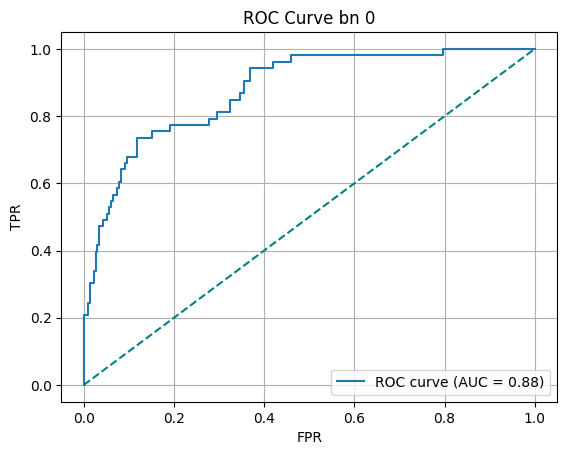

In [ ]:
int2label_dct, label2int_dct = load_labelintdcts()
metriclog = {}
exps = range(10)#[0,3,6]#[6]#[0,3,6,9]#
torch.cuda.empty_cache()
gc.collect()
model_name = "xlm-roberta-base"
#model_name = "microsoft/Multilingual-MiniLM-L12-H384"
#model_name = "distilbert-base-multilingual-cased"
#model_name = "paraphrase-multilingual-MiniLM-L12-v2"
''''''
for r in exps:
    letter = "N"
    mode = "bn"
    output_dir = cwd+f"/outputs/fting_{letter}_{mode}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    ds = DatasetDict.load_from_disk(f"{input_dir}/ds_{r}_{mode}")
    hyper = {
        "epochs":5, 
        "r":r, 
        "lr":2E-5,
        "batch_size":16,
        "loss":None,
        "oversampling":None,
        "span_step":None
        }
    print(r, "A", torch.cuda.memory_allocated())
    torch.cuda.empty_cache()
    gc.collect()
    print(r, "B", torch.cuda.memory_allocated())
    metrics = finetune_roberta(ds, int2label_dct[mode], label2int_dct[mode], mode, model_name=model_name, dev='cuda', output_dir=output_dir, hyperparams=hyper)
    print(r, "C", torch.cuda.memory_allocated())
    metriclog[f'{mode}_{r}'] = metrics
    hyp_rpt = {mode:hyper}
    with open(output_dir+f"/run_details.json", "w", encoding="utf-8") as f:
        json.dump(hyp_rpt, f, ensure_ascii=False, indent=4)
    torch.cuda.empty_cache()
    gc.collect()
    print(r, "D", torch.cuda.memory_allocated())

''''''
for r in exps:
    letter = "O"
    mode = "mc"
    output_dir = cwd+f"/outputs/fting_{letter}_{mode}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    ds = DatasetDict.load_from_disk(f"{input_dir}/ds_{r}_{mode}")
    hyper = {
        "epochs":15, 
        "r":r, 
        "lr":2E-5,
        "batch_size":16,
        "loss":None,
        "oversampling":None,
        "span_step":None
        }
    torch.cuda.empty_cache()
    gc.collect()
    metrics = finetune_roberta(ds, int2label_dct[mode], label2int_dct[mode], mode, model_name=model_name, dev='cuda', output_dir=output_dir, hyperparams=hyper)
    metriclog[f'{mode}_{r}'] = metrics
    hyp_rpt = {mode:hyper}
    with open(output_dir+f"/run_details.json", "w", encoding="utf-8") as f:
        json.dump(hyp_rpt, f, ensure_ascii=False, indent=4)
    torch.cuda.empty_cache()
    gc.collect()
    time.sleep(3)
    print(r, "D", torch.cuda.memory_allocated())

print(metriclog)